In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# parameters
lr = 0.0002
epochs = 40000
batch_size = 128
disp_step = 1000
examples_to_show = 10

In [3]:
# PARAMETERS 
num_in = 784
hidd_gen = 256
hidd_disc = 256
latent = 100

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))


# weights as dictionaries
weights = {
    'generator_w1': tf.Variable(glorot_init([latent, hidd_gen])),
    'generator_b1': tf.Variable(tf.zeros([hidd_gen])),
    'generator_wout': tf.Variable(glorot_init([hidd_gen, num_in])),
    'generator_bout': tf.Variable(tf.zeros([num_in])),
    #
    'discriminator_w1': tf.Variable(glorot_init([num_in, hidd_disc])),
    'discriminator_b1': tf.Variable(tf.zeros([hidd_disc])),
    'discriminator_wout': tf.Variable(glorot_init([hidd_disc, 1])),
    'discriminator_bout': tf.Variable(tf.zeros([1])),
}

In [4]:
# DEFINE MODEL wrappers

def generator(x):
    lay1 = tf.nn.relu(tf.add(tf.matmul(x, weights['generator_w1']), weights['generator_b1']))
    lay2 = tf.nn.sigmoid(tf.add(tf.matmul(lay1, weights['generator_wout']), weights['generator_bout']))
    return lay2
    

def discriminator(z):
    lay1 = tf.nn.relu(tf.add(tf.matmul(z, weights['discriminator_w1']), weights['discriminator_b1']))
    lay2 = tf.nn.sigmoid(tf.add(tf.matmul(lay1, weights['discriminator_wout']), weights['discriminator_bout']))
    return lay2


In [5]:
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, latent], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, num_in], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

In [6]:
# COSTs

# generative loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))

# discriminative loss
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))


In [7]:
# OPTIMISATION

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['generator_w1'], weights['generator_b1'],
            weights['generator_wout'], weights['generator_bout']]
# Discriminator Network Variables
disc_vars = [weights['discriminator_w1'], weights['discriminator_b1'],
            weights['discriminator_wout'], weights['discriminator_bout']]

# optimise separately
op_optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr).minimize(gen_loss, var_list=gen_vars)
op_optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr).minimize(disc_loss, var_list=disc_vars)



In [8]:
# INIT
init = tf.global_variables_initializer()

In [9]:
###  TRAINING SESSION
s = tf.Session()
s.run(init)

for i in range(epochs):
    batch_xs, _ = mnist.train.next_batch(batch_size)
    
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, latent])
    
    # Run optimization op (backprop) and cost op (to get loss value)
    _, _, gl, dl = s.run([op_optimizer_gen, op_optimizer_disc, gen_loss, disc_loss], feed_dict={disc_input: batch_xs, gen_input: z})
   
    # Display logs per step
    if i % disp_step == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
    

Step 0: Generator Loss: 0.764376, Discriminator Loss: 1.318438
Step 1: Generator Loss: 1.139799, Discriminator Loss: 1.102726
Step 1000: Generator Loss: 3.763243, Discriminator Loss: 0.054304
Step 2000: Generator Loss: 4.983060, Discriminator Loss: 0.038412
Step 3000: Generator Loss: 5.254200, Discriminator Loss: 0.019023
Step 4000: Generator Loss: 5.399263, Discriminator Loss: 0.026518
Step 5000: Generator Loss: 4.564936, Discriminator Loss: 0.052473
Step 6000: Generator Loss: 4.632036, Discriminator Loss: 0.075437
Step 7000: Generator Loss: 5.020441, Discriminator Loss: 0.087351
Step 8000: Generator Loss: 4.166502, Discriminator Loss: 0.086892
Step 9000: Generator Loss: 4.170550, Discriminator Loss: 0.118591
Step 10000: Generator Loss: 4.532072, Discriminator Loss: 0.175294
Step 11000: Generator Loss: 3.848418, Discriminator Loss: 0.220073
Step 12000: Generator Loss: 3.733015, Discriminator Loss: 0.169864
Step 13000: Generator Loss: 4.106462, Discriminator Loss: 0.177251
Step 14000: 

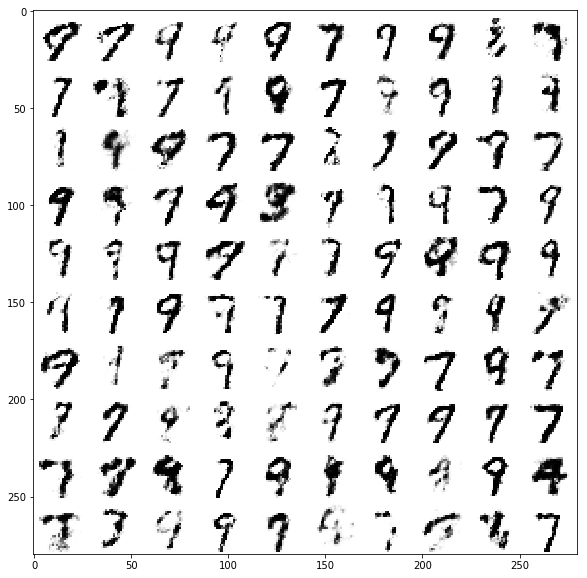

In [10]:
###  TESTING SESSION

# Generate images from noise, using the generator network.
n = examples_to_show
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, latent])
    # Generate image from noise.
    g = s.run(gen_sample, feed_dict={gen_input: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

